<a href="https://colab.research.google.com/github/lee-euijin/AppleFarm/blob/main/Model/skeleton_preprocessing_and_Model_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle data를 skeleton화 하여 Training

## Data upload

* mount drive, copy and unzip in the local directory

In [ ]:
# mount Google Drive
from google.colab import drive
import os
drive.mount('/content/gdrive')

# unzip
import zipfile, shutil

dataset = '/content/gdrive/My Drive/학교 수업 자료/딥러닝/Project/static_data.zip'
dst_path = '/content/static_data'
dst_file = os.path.join(dst_path, 'static_data.zip')

if not os.path.exists(dst_path):
  os.makedirs(dst_path)

shutil.copy(dataset, dst_file)

with zipfile.ZipFile(dst_file, 'r') as file:
  file.extractall(dst_path)

Mounted at /content/gdrive


* 이미지의 경로를 imagepaths list에 저장

In [ ]:
import os
imagepaths = []

for dirname, _, filenames in os.walk('/content/static_data'):
  for filename in filenames:
    path = os.path.join(dirname, filename)
    if path.endswith("png"):
      imagepaths.append(path)

print(len(imagepaths))
print(imagepaths[0])

40000
/content/static_data/leapgestrecog/leapGestRecog/02/07_ok/frame_02_07_0145.png


* kaggle의 데이터를 skeleton으로 변형할 구글 드라입 내의 directory 생성

In [ ]:
# google drive에 directory 추가
dir_path = '/content/gdrive/My Drive/학교 수업 자료/딥러닝/Project/static_skeleton_data'

for path in imagepaths[:19999]:
  splitted = path.split("/")

  # 없으면 directory 추가
  dir = os.path.join(dir_path, splitted[5])

  if not os.path.exists(dir):
    os.makedirs(dir)

  dir = os.path.join(dir_path, splitted[5], splitted[6])

  if not os.path.exists(dir):
    os.makedirs(dir)

## Data Preprocessing

In [ ]:
!pip install mediapipe opencv-python

     |████████████████████████████████| 36.1MB 85kB/s 


### Data Preprocessing and Saving

In [ ]:
* kaggle 데이터를 skeleton data로 바꾸어 미리 생성해둔 directory 내에 저장

In [ ]:
# 최초 save 이후에는 이 셀 실행하지 않음!
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
import mediapipe as mp
from google.colab.patches import cv2_imshow

new_path = []

# 저장을 위한 path 생성
for path in imagepaths[:19999]:
  splitted = path.split("/")
  temp = '/' + splitted[5] + '/' + splitted[6] + '/' + splitted[7]
  new_path.append(temp)

# train data preprocessing and save
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5) as hands:
  for idx in range(19999):
    # read an image, flip it around y-axis for correct handedness output
    image = cv.imread(imagepaths[idx])
    # convert the bgr image to rgb before processing
    results = hands.process(cv.cvtColor(image, cv.COLOR_BGR2RGB))

    # print handedness and draw hand landmarks on the image
    # print('Handedness:', results.multi_handedness)
    if not results.multi_hand_landmarks:
      continue
    image_height, image_width, _ = image.shape
    annotated_image = image.copy()

    # landmark만 그릴 image
    landmark_image = np.zeros(image.shape)
    for hand_landmarks in results.multi_hand_landmarks:
      '''print('hand_landmarks:', hand_landmarks)
      print(
          f'Index finger tip coordinates: (',
          f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width}, '
          f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height}'
      )'''
      mp_drawing.draw_landmarks(
          landmark_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    '''# imshow
    cv2_imshow(annotated_image)
    cv2_imshow(landmark_image)'''
    
    # save
    cv.imwrite(dir_path + new_path[idx], landmark_image)

IndexError: ignored

* index를 잘못 설정하여 에러가 발생했지만, 정상적으로 모두 저장되었다.

### path 확인

In [ ]:
skeletonpaths = []

for dirname, _, filenames in os.walk(dir_path):
  for filename in filenames:
    path = os.path.join(dirname, filename)
    if path.endswith("png"):
      skeletonpaths.append(path)

print(len(skeletonpaths)) # 6766개 데이터 유실
print(skeletonpaths[0])

13234
/content/gdrive/My Drive/학교 수업 자료/딥러닝/Project/static_skeleton_data/00/05_thumb/frame_00_05_0113.png


# Webcam에서 직접 만든 Training Data로 학습

## Data upload

* mount drive, copy and unzip in the local directory

In [ ]:
# mount Google Drive
from google.colab import drive
import os
drive.mount('/content/gdrive')

# unzip
import zipfile, shutil

dataset = '/content/gdrive/My Drive/학교 수업 자료/딥러닝/Project/static_data.zip'
dst_path = '/content/static_data'
dst_file = os.path.join(dst_path, 'static_data.zip')

if not os.path.exists(dst_path):
  os.makedirs(dst_path)

shutil.copy(dataset, dst_file)

with zipfile.ZipFile(dst_file, 'r') as file:
  file.extractall(dst_path)

Mounted at /content/gdrive


* 이미지의 경로를 imagepaths list에 저장

In [ ]:
import os
imagepaths = []

for dirname, _, filenames in os.walk('/content/static_data'):
  for filename in filenames:
    path = os.path.join(dirname, filename)
    if path.endswith("png"):
      imagepaths.append(path)

print(len(imagepaths))
print(imagepaths[0])

40000
/content/static_data/leapgestrecog/leapGestRecog/02/07_ok/frame_02_07_0145.png


## Data Preprocessing

In [ ]:
!pip install mediapipe opencv-python

     |████████████████████████████████| 36.1MB 85kB/s 


### Data Preprocessing and Saving

# Training

In [ ]:
import tensorflow as tf
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout

* X, y 변수 생성

In [ ]:
# Creating trainig set and labels
X = []
y = []

for path in skeletonpaths[:13234]:
  # image data
  img = cv.imread(path)
  img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  img = cv.resize(img, (128, 128))
  X.append(img)
  print(len(X))

  # labels
  category = path.split("/")[9] # path에서 9번째가 label
  label = int(category.split("_")[0][1])
  y.append(label)

X = np.array(X)
X = X.reshape(len(skeletonpaths), 128, 128, 1)
y = np.array(y)

print("이미지 개수 : ", len(X))
print("라벨 개수 : ", len(y))
print(y[0], skeletonpaths[0])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
8238
8239
8240
8241
8242
8243
8244
8245
8246
8247
8248
8249
8250
8251
8252
8253
8254
8255
8256
8257
8258
8259
8260
8261
8262
8263
8264
8265
8266
8267
8268
8269
8270
8271
8272
8273
8274
8275
8276
8277
8278
8279
8280
8281
8282
8283
8284
8285
8286
8287
8288
8289
8290
8291
8292
8293
8294
8295
8296
8297
8298
8299
8300
8301
8302
8303
8304
8305
8306
8307
8308
8309
8310
8311
8312
8313
8314
8315
8316
8317
8318
8319
8320
8321
8322
8323
8324
8325
8326
8327
8328
8329
8330
8331
8332
8333
8334
8335
8336
8337
8338
8339
8340
8341
8342
8343
8344
8345
8346
8347
8348
8349
8350
8351
8352
8353
8354
8355
8356
8357
8358
8359
8360
8361
8362
8363
8364
8365
8366
8367
8368
8369
8370
8371
8372
8373
8374
8375
8376
8377
8378
8379
8380
8381
8382
8383
8384
8385
8386
8387
8388
8389
8390
8391
8392
8393
8394
8395
8396
8397
8398
8399
8400
8401
8402
8403
8404
8405
8406
8407
8408
8409
8410
8411
8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430

* 생성한 변수 (X, y) 저장

In [ ]:
# data 저장
import pickle

with open('/content/gdrive/My Drive/학교 수업 자료/딥러닝/Project/input_data.pickle', 'wb') as f:
  pickle.dump(X, f, pickle.HIGHEST_PROTOCOL)

with open('/content/gdrive/My Drive/학교 수업 자료/딥러닝/Project/label_data.pickle', 'wb') as f:
  pickle.dump(y, f, pickle.HIGHEST_PROTOCOL)

'''
data 불러오기
with open('/content/gdrive/My Drive/학교 수업 자료/딥러닝/Project/input_data.pickle', 'rb') as f:
  X = pickle.load(f)
'''

"\ndata 불러오기\nwith open('/content/gdrive/My Drive/학교 수업 자료/딥러닝/Project/input_data.pickle', 'rb') as f:\n  X = pickle.load(f)\n"

* training

In [ ]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

# model
model = Sequential()
model.add(Conv2D(32, (5,5), activation='relu', input_shape=(128,128,1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dropout(0.3)) # dropout
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       1

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=2, 
          validation_data=(X_test, y_test))

Epoch 1/10
166/166 - 46s - loss: 0.8049 - accuracy: 0.7639 - val_loss: 0.2133 - val_accuracy: 0.9384
Epoch 2/10
166/166 - 3s - loss: 0.1543 - accuracy: 0.9515 - val_loss: 0.1810 - val_accuracy: 0.9516
Epoch 3/10
166/166 - 3s - loss: 0.1013 - accuracy: 0.9688 - val_loss: 0.1062 - val_accuracy: 0.9713
Epoch 4/10
166/166 - 3s - loss: 0.0548 - accuracy: 0.9827 - val_loss: 0.1549 - val_accuracy: 0.9603
Epoch 5/10
166/166 - 3s - loss: 0.0590 - accuracy: 0.9807 - val_loss: 0.1063 - val_accuracy: 0.9743
Epoch 6/10
166/166 - 3s - loss: 0.0360 - accuracy: 0.9869 - val_loss: 0.1114 - val_accuracy: 0.9777
Epoch 7/10
166/166 - 3s - loss: 0.0392 - accuracy: 0.9860 - val_loss: 0.1320 - val_accuracy: 0.9713
Epoch 8/10
166/166 - 3s - loss: 0.0299 - accuracy: 0.9899 - val_loss: 0.1214 - val_accuracy: 0.9754
Epoch 9/10
166/166 - 3s - loss: 0.0272 - accuracy: 0.9917 - val_loss: 0.1128 - val_accuracy: 0.9754
Epoch 10/10
166/166 - 3s - loss: 0.0266 - accuracy: 0.9908 - val_loss: 0.1111 - val_accuracy: 0.976

* result

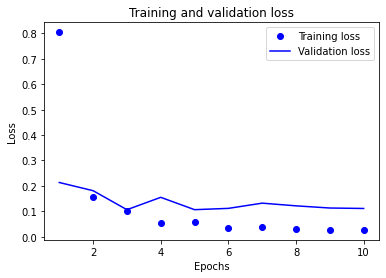

In [ ]:
# plotting
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* model save

In [ ]:
# model save
from tensorflow import keras
model.save('/content/gdrive/My Drive/학교 수업 자료/딥러닝/Project/model.h5')